<a href="https://colab.research.google.com/github/yohei0408/no.2/blob/main/%E3%83%95%E3%82%A1%E3%82%A4%E3%83%B3%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torchmetrics==0.11.4 pytorch_lightning==2.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 26.1 MB/s eta 0:00:00


In [2]:
import torchmetrics
from torchmetrics.functional import accuracy
torchmetrics.__version__

'0.11.4'

In [3]:
import pytorch_lightning as pl

pl.__version__

'2.0.2'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_val = datasets.CIFAR10('./', train=True, download=True, transform=transform)
test = datasets.CIFAR10('./', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13867463.23it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
x, t = train_val[0]

In [7]:
x.shape

torch.Size([3, 32, 32])

In [8]:
t

6

In [9]:
x.permute(1, 2, 0).shape

torch.Size([32, 32, 3])

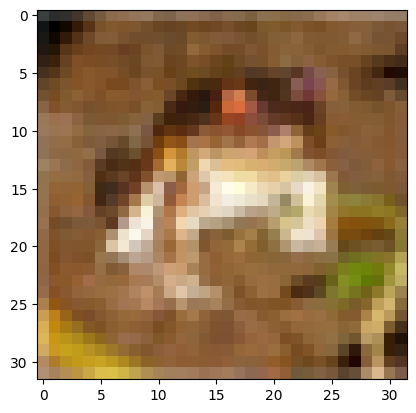

In [10]:
plt.imshow(x.permute(1, 2, 0));

In [11]:
t

6

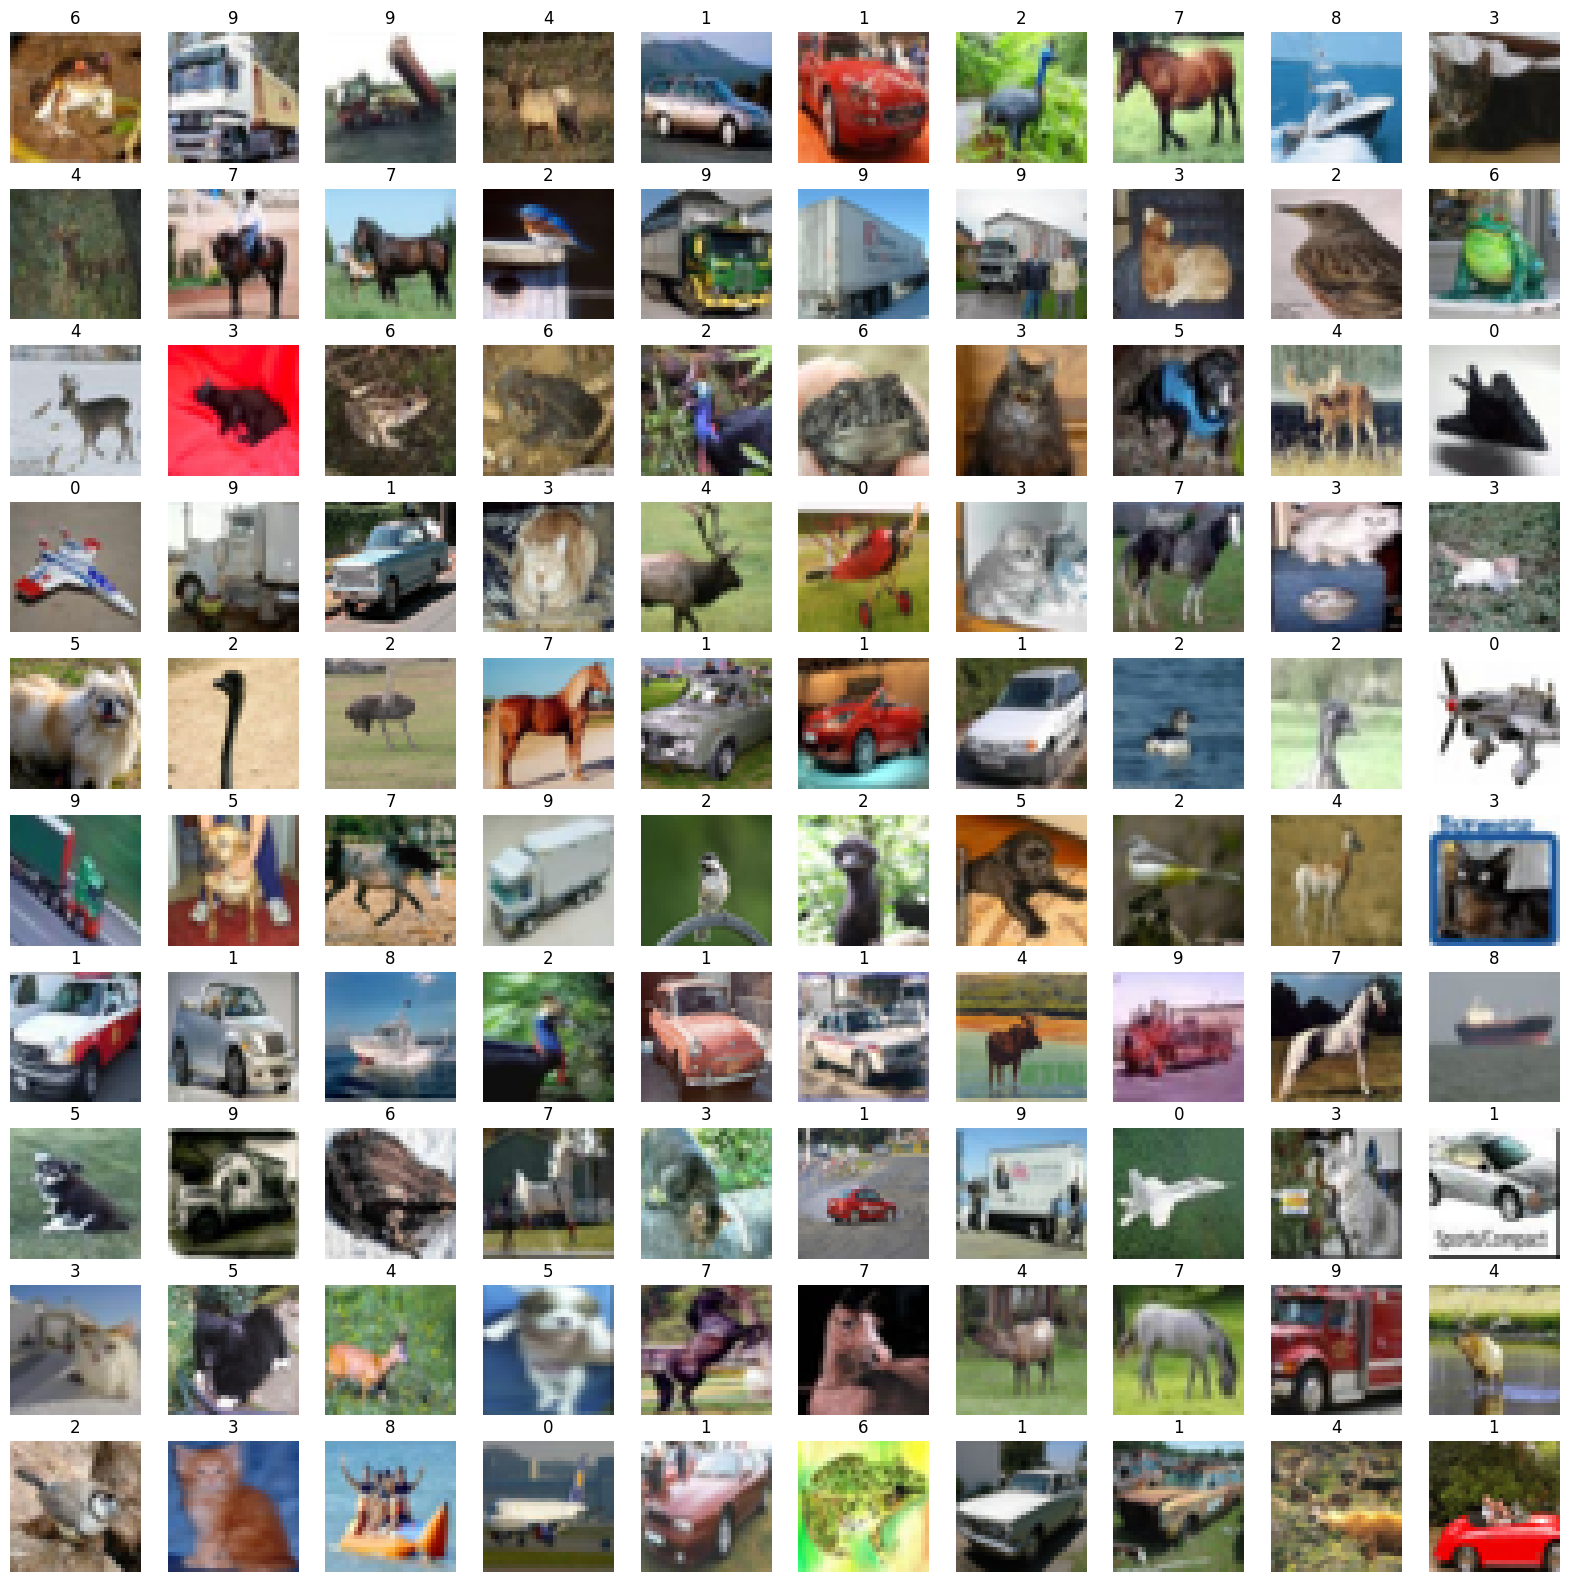

In [12]:
plt.figure(figsize=(20, 20))
for n in range(100):
  x, t = train_val[n]
  plt.subplot(10, 10, n+1)
  plt.title(train_val[n][1])
  plt.axis('off')
  plt.imshow(x.permute(1, 2, 0))

In [13]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
train_val = datasets.CIFAR10('./', train=True, download=True, transform=transform)
test = datasets.CIFAR10('./', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
len(train_val), len(test)

(50000, 10000)

In [16]:
pl.seed_everything(0)
n_train, n_val = 40000, 10000
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])
batch_size = 256

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [17]:
from torchvision.models import resnet18
feature = resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.9MB/s]


In [18]:
x, t = train[0]

In [19]:
x.shape

torch.Size([3, 224, 224])

In [20]:
h = feature(x.unsqueeze(0))
h.shape

torch.Size([1, 1000])

In [21]:
fc = nn.Linear(1000, 10)
h = fc(h)
h.shape

torch.Size([1, 10])

In [26]:
class Net(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.feature = resnet18(pretrained=True)
    self.fc = nn.Linear(1000, 10)

  def forward(self, x):
    h = self.feature(x)
    h = self.fc(h)
    return h

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('test_loss', loss, on_step=False, on_epoch=True)
    self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    return optimizer

SyntaxError: 'return' outside function (<ipython-input-26-93c3a97b618a>, line 1)

In [23]:
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=3, deterministic=False, logger=logger, accelerator='gpu')
trainer.fit(net, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | feature | ResNet | 11.7 M
1 | fc      | Linear | 10.0 K
-----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.798    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [24]:
results = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=2-step=468.ckpt
/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.909600019454956     │
│         test_loss         │    0.26203280687332153    │
└───────────────────────────┴───────────────────────────┘

In [25]:
feature = resnet18(pretrained=True)
for param in feature.parameters():
  param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
class Net(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.feature = resnet18(pretrained=True)
    for param in self.feature.parameters():
      param.requires_grad = False
    self.fc = nn.Linear(1000, 10)

  def forward(self, x):
    h = self.feature(x)
    h = self.fc(h)
    return h

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('test_loss', loss, on_step=False, on_epoch=True)
    self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    return optimizer

In [28]:
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp1')
trainer = pl.Trainer(max_epochs=3, accelerator='gpu', logger=logger, deterministic=False)
trainer.fit(net, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [29]:
results = trainer.test(dataloaders = test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp1/version_0/checkpoints/epoch=2-step=468.ckpt
/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rele

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.758400022983551     │
│         test_loss         │    0.7038293480873108     │
└───────────────────────────┴───────────────────────────┘